In [1]:
import torch
import os
import h5py
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from mpl_toolkits.mplot3d import proj3d
from utils import *

In [2]:
##### DISCRIMINATIVE - setup
src_logits = load_from_file('../resources/tensors/DGCNN_CE_SR1/src_logits.pt')
tar1_logits = load_from_file('../resources/tensors/DGCNN_CE_SR1/tar1_logits.pt')
tar2_logits = load_from_file('../resources/tensors/DGCNN_CE_SR1/tar2_logits.pt')

src_MSP_scores, src_MSP_pred = F.softmax(src_logits, dim=1).max(1)
tar1_MSP_scores, tar1_MSP_pred = F.softmax(tar1_logits, dim=1).max(1)
tar2_MSP_scores, tar2_MSP_pred = F.softmax(tar2_logits, dim=1).max(1)

##### DISTANCE BASED - setup
src_feats = load_from_file('../resources/feats/DGCNN_CE_SR1.pt')

src_dist = load_from_file('../resources/tensors/DGCNN_CE_SR1/src_dist.pt')
src_ids = load_from_file('../resources/tensors/DGCNN_CE_SR1/src_ids.pt')
tar1_dist = load_from_file('../resources/tensors/DGCNN_CE_SR1/tar1_dist.pt')
tar1_ids = load_from_file('../resources/tensors/DGCNN_CE_SR1/tar1_ids.pt')
tar2_dist = load_from_file('../resources/tensors/DGCNN_CE_SR1/tar2_dist.pt')
tar2_ids = load_from_file('../resources/tensors/DGCNN_CE_SR1/tar2_ids.pt')

src_L2_dist = src_dist.squeeze().cpu()
src_L2_ids = src_ids.squeeze().cpu()  # index of nearest training sample
src_L2_scores = 1 / src_dist

tar1_L2_dist = tar1_dist.squeeze().cpu()
tar1_L2_ids = tar1_ids.squeeze().cpu()  # index of nearest training sample
tar1_L2_scores = 1 / tar1_dist

tar2_L2_dist = tar2_dist.squeeze().cpu()
tar2_L2_ids = tar2_ids.squeeze().cpu()  # index of nearest training sample
tar2_L2_scores = 1 / tar2_dist


# set OOD labels/truth
tar1_labels = torch.from_numpy(np.full((1,len(tar1_logits)), 404)).squeeze().cpu()
tar2_labels = torch.from_numpy(np.full((1,len(tar2_logits)), 404)).squeeze().cpu()
src_labels = load_from_file('../resources/tensors/DGCNN_CE_SR1/src_labels.pt')

Best value for threshold: 0.98989898989899


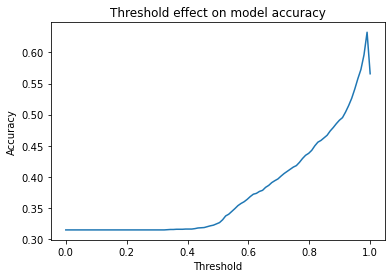

In [3]:
# compute MSP threshold
samples_MSP = torch.hstack((src_MSP_scores, tar1_MSP_scores, tar2_MSP_scores))
labels_MSP = torch.hstack((src_MSP_pred, tar1_MSP_pred, tar2_MSP_pred))
truth = torch.hstack((src_labels, tar1_labels, tar2_labels))
threshold_MSP = calculate_threshold(samples_MSP, labels_MSP, truth)

print("Best value for threshold: " + str(threshold_MSP))

Best value for threshold: 0.17171717171717174
(tensor([  52,   57,  150,  ..., 2887, 2888, 2889]),)


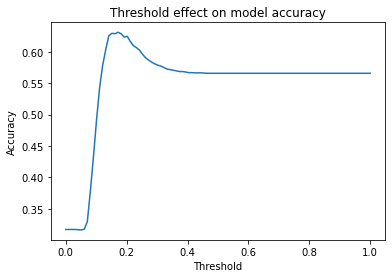

In [4]:
# compute L2 threshold

# train truth
train_labels = src_feats["train_labels"]

src_L2_pred = torch.from_numpy(train_labels[src_ids])
tar1_L2_pred = torch.from_numpy(train_labels[tar1_ids])
tar2_L2_pred = torch.from_numpy(train_labels[tar2_ids])

ids_L2 = torch.hstack((src_L2_ids, tar1_L2_ids, tar2_L2_ids))
scores_L2 = torch.hstack((src_L2_scores, tar1_L2_scores, tar2_L2_scores))
labels_L2 = torch.hstack((src_L2_pred, tar1_L2_pred, tar2_L2_pred))
truth = torch.hstack((src_labels, tar1_labels, tar2_labels))

l2_threshold = calculate_threshold(scores_L2, labels_L2, truth)
print("Best value for threshold: " + str(l2_threshold))

# misclassified samples
misclas_samples_ids = (~labels_L2.eq(truth)).nonzero(as_tuple=True)
correctly_clas_samples_ids = (labels_L2.eq(truth)).nonzero(as_tuple=True)

print(misclas_samples_ids)
# print(correctly_clas_samples_ids)

In [5]:
# miscalssified samples visualization

SR1 = {
    4: 0,  # chair
    8: 1,  # shelf
    7: 2,  # door
    12: 3,  # sink
    13: 4  # sofa
}

SR2 = {
    10: 0,  # bed
    14: 1,  # toilet
    5: 2,  # desk
    6: 3,  # display
    9: 2  # table
}

SR3 = {
    0: 404,  # bag
    1: 404,  # bin
    2: 404,  # box
    3: 404,  # cabinet
    11: 404  # pillow
}

test_file = h5py.File('../3D_OS_release_data/ScanObjectNN/h5_files/main_split/test_objectdataset.h5', 'r')
train_file = h5py.File('../3D_OS_release_data/ScanObjectNN/h5_files/main_split/training_objectdataset.h5', 'r')

test_labels  = test_file['label'][:]
train_labels = train_file['label'][:]

test_clouds = test_file['data'][:]
train_clouds = train_file['data'][:]

all_labels = np.hstack((train_labels, test_labels))
all_clouds = np.vstack((train_clouds, test_clouds))

SR1_indices = [index for index, value in enumerate(all_labels) if value in SR1.keys()]
SR2_indices = [index for index, value in enumerate(all_labels) if value in SR2.keys()]
SR3_indices = [index for index, value in enumerate(all_labels) if value in SR3.keys()]

SR1_clouds = all_clouds[SR1_indices]
SR2_clouds = all_clouds[SR2_indices]
SR3_clouds = all_clouds[SR3_indices]

SR1_labels = [SR1[all_labels[id]] for id in SR1_indices]
SR2_labels = [SR2[all_labels[id]] for id in SR2_indices]
SR3_labels = [404 for _ in SR3_indices]

<class 'tuple'>
[2356, 1306, 1948]


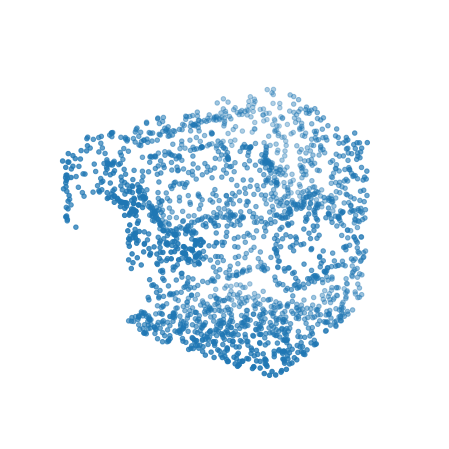

sofa


In [25]:
# visualization 
id = 840
print(type(misclas_samples_ids))

# random from sr1, sr2 and sr3
print(sample(misclas_samples_ids[0].tolist(), 3))

render_cloud(SR1_clouds[id])
print(lab_to_text_sr1[SR1_labels[id]])